# Notebook containing our code for searching and analyzing platforms where posters are shared

## Imports

In [37]:
import json
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from googlesearch import search

In [38]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Finding platform where posters are shared

Note: The combined results from all methods are in the "poster-platforms-review.xlsx" file included in the dataset associated witht his work (see README for details)

### Method 1: Google search

In [39]:
rows_list = []
count = 0
for result in search("poster sharing publication", num=100, stop=100):
    count += 1
    rows_list.append([count, result])
df = pd.DataFrame(rows_list, columns=["index", "link"])
df.to_csv("outputs/find-posters/find-posters-google.csv", index=False)

### Method 2: Query LLMs

Done manually on https://openai.com/index/chatgpt/ and https://gemini.google.com/

### Method 3: Look at Datacite's poster related DOI

There is no specific category (or resourceType) for posters in the DataCite schema. However, it seems that platforms like Zenodo that publish posters enter "Poster" as a free text for the "resourceType" when generating a DOI for posters. So we queried the Datacite API for all resourceType set to "Poster" to find their related platforms. Note that that some platforms may register posters under a different resourceType. For instance, F1000Research use resourceType "Other" for posters. This mean that not all publishing posters with DOIs would be found with this method.

#### Get all posters metadata from Datacite

In [ ]:
# Note: the results of this code are already in the datacite.json file included in the output folder
# That file is from a run of this code on January 26th 2025
dict_results = {}
count = 0
next_page = True
get_link = "https://api.datacite.org/dois?query=types.resourceType:Poster&page[cursor]=1&page[size]=1000"

while next_page:
    r = json.loads(requests.get(get_link).content)
    for result in r["data"]:
        dict_results[count] = result
        count += 1
    if "next" in r["links"].keys():
        get_link = r["links"]["next"]
    else:
        next_page = False

# Save results in a json file so we don't have to run this multiple time for post-processing and analysis
with open("outputs/records/datacite.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

#### Get publisher information from the posters

In [ ]:
# load data
with open("outputs/records/datacite.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [ ]:
# Get platform info and one poster doi from each publisher to have an example poster from each
rows_list = []
cliend_id_list = []
for result in results.values():
    client_id = result["relationships"]["client"]["data"]["id"]
    if client_id not in cliend_id_list:
        cliend_id_list.append(client_id)
        get_client_link = "https://api.test.datacite.org/clients/" + client_id
        r = json.loads(requests.get(get_client_link).content)
        if "data" in r.keys():
            result_client = r["data"]
            client_name = result_client["attributes"]["name"]
            client_domains = result_client["attributes"]["domains"]
        else:
            client_name = "NA"
            client_domains = "NA"

        poster_doi = result["attributes"]["doi"]
        poster_doi_link = "https://doi.org/" + poster_doi

        rows_list.append(
            [client_id, client_name, client_domains, poster_doi, poster_doi_link]
        )
# save
df = pd.DataFrame(
    rows_list,
    columns=[
        "Platform id on Datacite",
        "Platform name",
        "Platform domains",
        "Example poster DOI",
        "Example poster DOI link",
    ],
)
df.to_csv("outputs/find-posters/find-posters-datacite.csv", index=False)

In [ ]:
# Remove institution specific figshare instances as the related posters are also found in the main figshare site
main_figshare_id = "figshare.ars"
for index, row in df.iterrows():
    client_id = row["Platform id on Datacite"]
    client_domains = row["Platform domains"]
    if "figshare" in client_id or "figsh" in client_domains:
        if client_id != main_figshare_id:
            df = df.drop(index)
df.to_csv("outputs/find-posters/find-posters-datacite.csv", index=False)

# Import the file and call the main manuscript

In [ ]:
datafilename = "poster-platforms-results.xlsx"
datafilepath = os.path.join("inputs", "dataset", "primary", "find-posters", datafilename)
df = pd.read_excel(datafilepath, sheet_name="overview")

# Total and poster-containing platform count

In [18]:
platformlink_count = df['platformName'].count()
platformlink_unique_count = df['platformName'].nunique()
unique_rows_count = len(df.drop_duplicates())
poster_df = df[df['containsPoster'].str.lower() == "yes"]

print(f"Total number of platforms: {platformlink_unique_count}")
print(f"All platforms that contain poster: {poster_df['platformName'].nunique()}")



Total number of platforms: 151
All platforms that contain poster: 104


# Total platforms that contains poster and is not derived

In [19]:
filtered_df = df[
    (df['containsPoster'].str.lower() == "yes") &
    (df['isDerived'].str.lower() == "no")
]
# Count total rows that match
total_row_count = len(filtered_df)
print(f"Total rows where containsPoster = 'yes' AND isDerived = 'no': {total_row_count}")

Total rows where containsPoster = 'yes' AND isDerived = 'no': 86


# Search methods:1.   Google 2.   LLM  3.   DataCite


In [20]:
# --- Count total rows ---
total_rows = len(filtered_df)

# --- Count rows by exact searchMethod values ---
count_1 = (filtered_df['searchMethod'] == 1).sum()
count_2 = (filtered_df['searchMethod'] == 2).sum()
count_3 = (filtered_df['searchMethod'] == 3).sum()

print(f"Total rows (containsPoster = yes, isDerived = no): {total_rows}")
print(f"Rows with searchMethod = 1-google: {count_1}")
print(f"Rows with searchMethod = 2-LLM: {count_2}")
print(f"Rows with searchMethod = 3-Datacite: {count_3}")


Total rows (containsPoster = yes, isDerived = no): 86
Rows with searchMethod = 1-google: 5
Rows with searchMethod = 2-LLM: 9
Rows with searchMethod = 3-Datacite: 67


# Total count of published posters that contributed to total counting

In [21]:
# --- Clean up totalPosters column ---
df['totalPosters'] = pd.to_numeric(df['totalPosters'].replace("na", pd.NA), errors='coerce')

# --- Apply filters (all platforms) ---
filtered_df_ = df[
    (df['containsPoster'].str.lower() == "yes") &
    (df['isDerived'].str.lower() == "no") &
    df['totalPosters'].notna() &
    (df['totalPosters'] != -1)]

# --- Count and sum ---
row_count = len(filtered_df_)
total_posters_sum = filtered_df_['totalPosters'].sum()

print(f"Valid rows (all platforms, containsPoster=yes, isDerived=no): {row_count}")
print(f"Sum of totalPosters: {total_posters_sum}")


Valid rows (all platforms, containsPoster=yes, isDerived=no): 43
Sum of totalPosters: 150013.0


# Sum of 4 platform poster count- NTRS, F1000, ZENODO, Figshare that only yearwsise count was possible

In [22]:
# --- Clean up totalPosters column ---
df['totalPosters'] = pd.to_numeric(df['totalPosters'].replace("na", pd.NA), errors='coerce')

# --- Apply filters (all platforms) ---
filtered_df_ = df[
    (df['containsPoster'].str.lower() == "yes") &
    (df['isDerived'].str.lower() == "no") &
    (df['hasSharingDate'].str.lower() == "yes")
]

# --- Count and sum ---
row_count = len(filtered_df_)
yearwise_posters_sum = filtered_df_['totalPosters'].sum()

print(f"Valid rows (all platforms, containsPoster=yes, isDerived=no, hasSharingDate=yes): {row_count}")
print(f"Sum of totalPosters (hasSharingDate=yes): {yearwise_posters_sum}")


Valid rows (all platforms, containsPoster=yes, isDerived=no, hasSharingDate=yes): 4
Sum of totalPosters (hasSharingDate=yes): 55317.0


# 4 mostly shared platform: Zenodo, Figshare, Digital commons and F1000Research poster count

In [23]:
filtered_df_3 = df[
    (df['containsPoster'].str.lower() == "yes") &
                 df['platformName'].isin(["Zenodo", "Figshare", "F1000Research", "Digital Commons"]) &

    (df['isDerived'].str.lower() == "no") &
    df['totalPosters'].notna() &
    (df['totalPosters'] != -1)

]

# --- Count and sum ---
row_count = len(filtered_df_3)
total_three_platform_sum = filtered_df_3['totalPosters'].sum()
percentage = (total_three_platform_sum / total_posters_sum * 100) if total_posters_sum > 0 else 0

print(f"Valid rows (platform = Zenodo/Figshare/F1000Research/DigitalCommons, containsPoster=yes, isDerived=no): {row_count}")
print(f"Sum of total 4 Posters: {total_three_platform_sum} and total poster: {total_posters_sum}")
print(f"Percentage: {percentage:.2f}%")



Valid rows (platform = Zenodo/Figshare/F1000Research/DigitalCommons, containsPoster=yes, isDerived=no): 4
Sum of total 4 Posters: 134645.0 and total poster: 150013.0
Percentage: 89.76%


# Count mostly used platforms that has a DOI

In [24]:
valid_posters_all = df[df['totalPosters'] != -1]
total_posters_sum = valid_posters_all['totalPosters'].sum()

#  Filtered: hasDOI = yes AND valid totalPosters
filtered_df_doi_ = df[
    (df['hasDOI'].str.lower() == "yes") &
    (df['totalPosters'].notna()) &
    (df['containsPoster'].str.lower() == "yes") &
    (df['isDerived'].str.lower() == "no") &
    (df['totalPosters'] != -1)
]

sum_posters = filtered_df_doi_['totalPosters'].sum()

#  Percentage
percentage = (sum_posters / total_posters_sum) * 100 if total_posters_sum > 0 else 0

print(f"Total posters sum (all valid): {total_posters_sum}")
print(f"Total posters sum (hasDOI = yes): {sum_posters}")
print(f"Percentage: {percentage:.2f}%")


Total posters sum (all valid): 150013.0
Total posters sum (hasDOI = yes): 62873.0
Percentage: 41.91%


# Identifier count

In [25]:
posters_df = df[
    (df['containsPoster'].str.lower() == "yes") &
    (df['isDerived'].str.lower() == "no")
].copy()

# --- Filter rows where hasDOI = "yes" as well ---
doi_posters_df = posters_df[
    posters_df['hasDOI'].str.lower() == "yes"
].copy()

# Make sure totalPosters is numeric
doi_posters_df.loc[:, 'totalPosters'] = pd.to_numeric(doi_posters_df['totalPosters'], errors='coerce')

# --- Counts and sums ---
unique_platforms_all = posters_df['platformName'].nunique()
unique_platforms_doi = doi_posters_df['platformName'].nunique()
total_posters_doi = doi_posters_df['totalPosters'].sum(skipna=True)
percentage = (unique_platforms_doi / unique_platforms_all * 100) if unique_platforms_all > 0 else 0
pers_for_total = total_posters_doi/total_posters_sum*100
# --- Output ---
print("For rows where containsPoster='yes' and isDerived='no':")
print(f"- Unique platforms total: {unique_platforms_all}")
print(f"- Unique platforms with DOI: {unique_platforms_doi}")
print(f"- Total number of posters (hasDOI='yes'): {int(total_posters_doi)}")

print(f"- Percentage: {percentage:.2f}%")
print(f"- DOI-issuing platforms account for: {pers_for_total:.2f}%")


For rows where containsPoster='yes' and isDerived='no':
- Unique platforms total: 86
- Unique platforms with DOI: 63
- Total number of posters (hasDOI='yes'): 62841
- Percentage: 73.26%
- DOI-issuing platforms account for: 41.89%


# Merged Figure 2 (a and b)

/tmp/ipython-input-2844523696.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(plot_data.index, rotation=15)
/tmp/ipython-input-2844523696.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


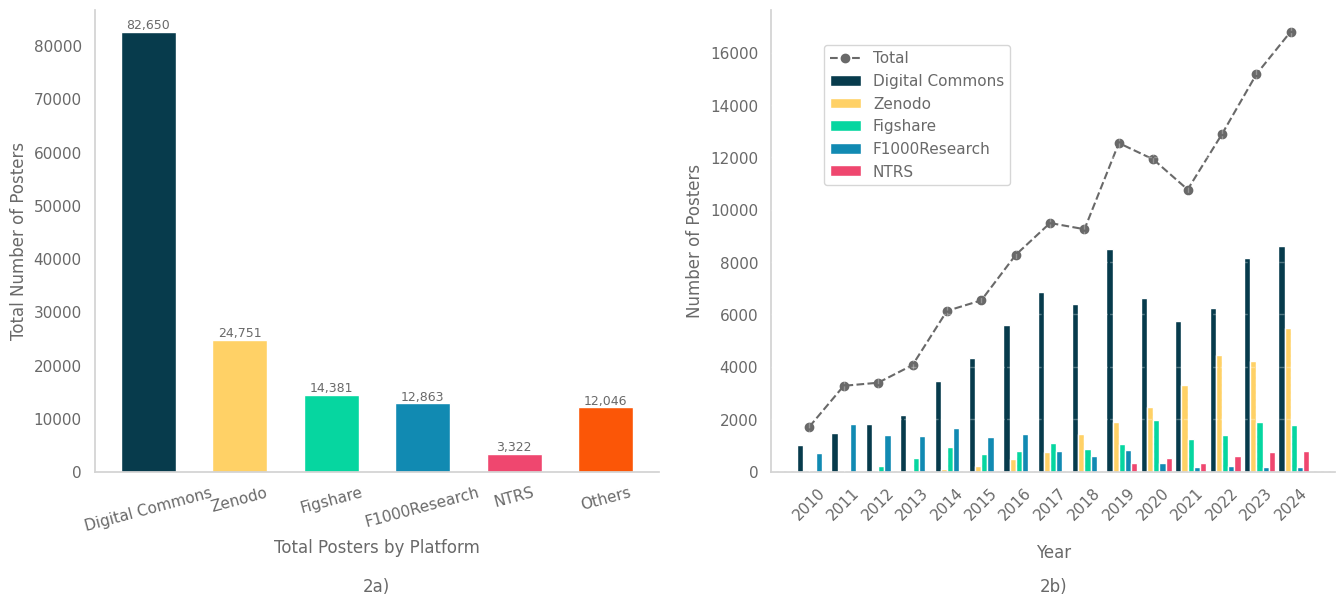

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- CONFIG ----------
platforms = ["Digital Commons", "Zenodo", "Figshare", "F1000Research"]
platforms_b = ["NTRS", "Zenodo", "Figshare", "F1000Research", ]
colors = ["#06d6a0", "#073b4c", "#ffd166", "#118ab2", "#ef476f", "#fb5607"]

output_dir = os.path.join("outputs", "find-posters")
os.makedirs(output_dir, exist_ok=True)

# Stable color mapping
all_platforms = list(dict.fromkeys(platforms + platforms_b + ["Others"]))
color_map = dict(zip(all_platforms, colors))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"wspace": 0.2})

df.columns = df.columns.str.strip()
df["platformName"] = df["platformName"].replace(
    {"NASA Technical Reports Server": "NTRS"}
)
df["isDerived"] = df["isDerived"].astype(str).str.strip().str.lower()
df["totalPosters"] = pd.to_numeric(df["totalPosters"], errors="coerce")

# ---------- FIGURE 2a ----------
poster_df = df.query(
    "isDerived == 'no' and totalPosters.notna() and totalPosters != -1"
)

main = (
    poster_df[poster_df["platformName"].isin(platforms)]
    .groupby("platformName")["totalPosters"]
    .sum()
    .reindex(platforms)
    .fillna(0)
)

others = poster_df.loc[
    ~poster_df["platformName"].isin(platforms),
    "totalPosters",
].sum()

plot_a = pd.concat([main, pd.Series(others, index=["Others"])])

bars = ax1.bar(
    plot_a.index,
    plot_a.values,
    color=[color_map[p] for p in plot_a.index],
    width=0.6,
)

ax1.set_xlabel("Platform", fontsize=12)
ax1.set_ylabel("Number of posters", fontsize=12)
ax1.set_xticklabels(plot_a.index, rotation=15)
ax1.text(
    -0.15, 1.02, "a",
    transform=ax1.transAxes,
    fontsize=12,
    fontweight="bold",
    clip_on=False,
)

for b in bars:
    ax1.text(
        b.get_x() + b.get_width() / 2,
        b.get_height(),
        f"{int(b.get_height()):,}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# ---------- FIGURE 2b ----------
xls = pd.ExcelFile(datafilepath)

df_yearly = pd.concat(
    [
        pd.read_excel(xls, s)
        .rename(columns=str.strip)
        .assign(
            numberPoster=lambda d: pd.to_numeric(
                d["numberPoster"], errors="coerce"
            ),
            platform=s,
        )
        .query("2010 <= year <= 2024")[["year", "numberPoster", "platform"]]
        for s in xls.sheet_names if s in platforms_b
    ],
    ignore_index=True,
)

pivot = (
    df_yearly.pivot(index="year", columns="platform", values="numberPoster")
    .fillna(0)
)

x = np.arange(len(pivot))
w = 0.18

for i, p in enumerate(platforms_b):
    ax2.bar(
        x + i * w,
        pivot[p],
        w,
        color=color_map[p],
        label=p,
    )

ax2.plot(
    x + w * 1.5,
    pivot.sum(axis=1),
    linestyle="--",
    marker="o",
    color="dimgray",
    label="Total",
)

ax2.set_xlabel("Year", fontsize=12, labelpad=11)
ax2.set_ylabel("Number of posters", fontsize=12)
ax2.set_xticks(x + w * 1.5)
ax2.set_xticklabels(pivot.index.astype(int), rotation=45)
ax2.text(
    -0.15, 1.02, "b",
    transform=ax2.transAxes,
    fontsize=12,
    fontweight="bold",
    clip_on=False,
)

ax2.legend(loc="upper left", bbox_to_anchor=(0.08, 0.94))
ax2.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
pivot = (
    df_yearly.pivot(index="year", columns="platform", values="numberPoster")
    .fillna(0)
)

x = np.arange(len(pivot))
w = 0.18

for i, p in enumerate(platforms_b):
    ax2.bar(
        x + i * w,
        pivot[p],
        w,
        color=color_map[p],
        label=p,
    )

ax2.plot(
    x + w * 1.5,
    pivot.sum(axis=1),
    linestyle="--",
    marker="o",
    color="dimgray",
    label="Total",
)

ax2.set_xlabel("Year", fontsize=12, labelpad=11)
ax2.set_ylabel("Number of posters", fontsize=12)
ax2.set_xticks(x + w * 1.5)
ax2.set_xticklabels(pivot.index.astype(int), rotation=45)
ax2.text(
    -0.15, 1.02, "b",
    transform=ax2.transAxes,
    fontsize=12,
    fontweight="bold",
    clip_on=False,
)

ax2.legend(loc="upper left", bbox_to_anchor=(0.08, 0.94))
ax2.grid(True, linestyle="--", alpha=0.3)

fig.tight_layout()
fig.savefig(
    os.path.join(output_dir, "figure_2.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.close(fig)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # left=2a, right=2b
